# **IDNIAN PINES**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score, pairwise_distances
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CNN Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 200, 128)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Load model
model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model_Checkpoints/PrototypicalNetwork_IP.pth", map_location=device))
model.eval()

# Load data
df = pd.read_csv("/content/drive/MyDrive/IndianPines.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.astype(int)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to torch tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long)

# Few-shot setup
n_way = 5
k_shot = 5
q_query = 10

unique_classes = np.unique(y)
selected_classes = np.random.choice(unique_classes, n_way, replace=False)

support_samples, support_labels = [], []
query_samples, query_labels = [], []

for idx, cls in enumerate(selected_classes):
    cls_indices = np.where(y == cls)[0]
    cls_indices = np.random.permutation(cls_indices)

    support_idx = cls_indices[:k_shot]
    query_idx = cls_indices[k_shot:k_shot+q_query]

    support_samples.append(X_tensor[support_idx])
    query_samples.append(X_tensor[query_idx])
    support_labels += [idx] * k_shot
    query_labels += [idx] * q_query

support_samples = torch.cat(support_samples, dim=0).to(device)
query_samples = torch.cat(query_samples, dim=0).to(device)

# Run model
with torch.no_grad():
    logits = model(support_samples, query_samples, n_way, k_shot)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

# Ground truth
query_labels = np.array(query_labels)

# Evaluation
accuracy = accuracy_score(query_labels, preds) * 100
kappa = cohen_kappa_score(query_labels, preds)
ari = adjusted_rand_score(query_labels, preds)

# Avg Interclass Distance (on prototype space)
with torch.no_grad():
    support_embeddings = model.feature_extractor(support_samples)
    prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1).cpu().numpy()
    dist_matrix = pairwise_distances(prototypes)
    upper_tri_indices = np.triu_indices_from(dist_matrix, k=1)
    avg_inter_dist = np.mean(dist_matrix[upper_tri_indices])

# Results
print(f"Overall Accuracy: {accuracy:.2f}%")
print(f"Cohen’s Kappa: {kappa:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Average Interclass Distance: {avg_inter_dist:.4f}")

Overall Accuracy: 84.00%
Cohen’s Kappa: 0.8000
Adjusted Rand Index: 0.7028
Average Interclass Distance: 14.0555


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

from sklearn.metrics import pairwise_distances
import numpy as np

# ✅ Compute Average Interclass Distance
unique_classes = np.unique(y_ground_truth)
class_means = []

for cls in unique_classes:
    cls_indices = np.where(y_ground_truth == cls)[0]
    if len(cls_indices) > 0:
        cls_features = deep_features[cls_indices]
        class_mean = np.mean(cls_features, axis=0)
        class_means.append(class_mean)

class_means = np.array(class_means)
dist_matrix = pairwise_distances(class_means)
upper_tri_indices = np.triu_indices_from(dist_matrix, k=1)
avg_interclass_dist = np.mean(dist_matrix[upper_tri_indices])

print(f"Average Interclass Distance: {avg_interclass_dist:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 709.33 ms
0:	learn: 2.1290462	total: 76.9ms	remaining: 1m 16s
50:	learn: 0.5313758	total: 1.54s	remaining: 28.6s
100:	learn: 0.4493258	total: 2.86s	remaining: 25.5s
150:	learn: 0.4068933	total: 5.25s	remaining: 29.5s
200:	learn: 0.3733796	total: 7.93s	remaining: 31.5s
250:	learn: 0.3481531	total: 9.25s	remaining: 27.6s
300:	learn: 0.3267830	total: 10.7s	remaining: 24.9s
350:	learn: 0.3073273	total: 12s	remaining: 22.2s
400:	learn: 0.2897962	total: 13.3s	remaining: 19.9s
450:	learn: 0.2734625	total: 14.7s	remaining: 17.8s
500:	learn: 0.2591941	total: 16s	remaining: 15.9s
550:	learn: 0.2455393	total: 17.3s	remaining: 14.1s
600:	learn: 0.2333037	total: 20.3s	remaining: 13.5s
650:	learn: 0.2204024	total: 22s	remaining: 11.8s
700:	learn: 0.2087422	total: 23.4s	remaining: 9.97s
750:	learn: 0.1988912	total: 24.7s	remaining: 8.19s
800:	learn: 0.1886875	total: 26.1s	remaining: 6.47s
850:	learn: 0.1793108	total: 

📌 Overlapping Classes:
Class 1: Alfalfa (46 samples)
Class 2: Corn-notill (1428 samples)
Class 3: Corn-mintill (830 samples)
Class 4: Corn (237 samples)
Class 5: Grass-pasture (483 samples)
Class 6: Grass-trees (730 samples)
Class 7: Grass-pasture-mowed (28 samples)
Class 9: Oats (20 samples)
Class 10: Soybean-notill (972 samples)
Class 11: Soybean-mintill (2455 samples)
Class 12: Soybean-clean (593 samples)
Class 13: Wheat (205 samples)
Class 14: Woods (1265 samples)
Class 15: Buildings-Grass-Trees-Drives (386 samples)
Class 16: Stone-Steel-Towers (93 samples)

Total Overlapping Classes: 15



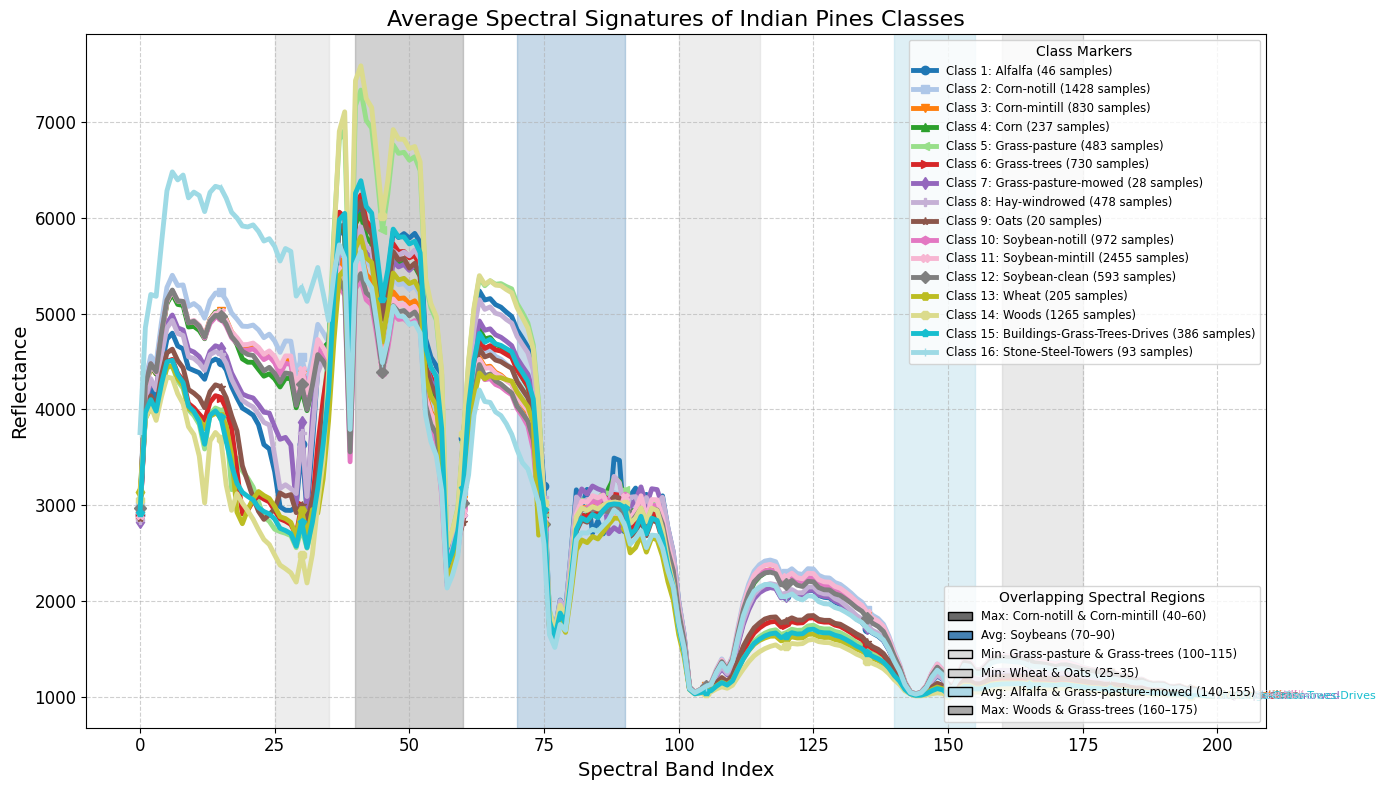

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load CSV file
data = pd.read_csv('/content/drive/MyDrive/IndianPines.csv')

# Separate features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Define all classes and overlapping subset (expanded)
classes_to_plot = list(range(1, 17))
overlapping_classes = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16]

# Mapping from class ID to (name, sample count)
class_info = {
    1: ("Alfalfa", 46),
    2: ("Corn-notill", 1428),
    3: ("Corn-mintill", 830),
    4: ("Corn", 237),
    5: ("Grass-pasture", 483),
    6: ("Grass-trees", 730),
    7: ("Grass-pasture-mowed", 28),
    8: ("Hay-windrowed", 478),
    9: ("Oats", 20),
    10: ("Soybean-notill", 972),
    11: ("Soybean-mintill", 2455),
    12: ("Soybean-clean", 593),
    13: ("Wheat", 205),
    14: ("Woods", 1265),
    15: ("Buildings-Grass-Trees-Drives", 386),
    16: ("Stone-Steel-Towers", 93)
}

# Print overlapping class info
print("📌 Overlapping Classes:")
for cls in overlapping_classes:
    name, count = class_info[cls]
    print(f"Class {cls}: {name} ({count} samples)")
print(f"\nTotal Overlapping Classes: {len(overlapping_classes)}\n")

wavelengths = np.arange(X.shape[1])

# Define unique markers and colors
markers = ['o', 's', 'v', '^', '<', '>', 'd', 'P', '*', 'h', 'X', 'D', 'H', '8', 'p', '|']
colors = plt.cm.tab20(np.linspace(0, 1, 16))

# Plot setup
plt.figure(figsize=(14, 8))
lines_all = []
labels_all = []
lines_overlap = []
labels_overlap = []

for idx, cls in enumerate(classes_to_plot):
    class_samples = X[y == cls]
    mean_spectrum = np.mean(class_samples, axis=0)
    line, = plt.plot(
        wavelengths, mean_spectrum,
        label=f'{class_info[cls][0]}',
        color=colors[idx],
        linewidth=3.5,
        marker=markers[idx],
        markevery=15,
        markersize=6
    )
    lines_all.append(line)
    labels_all.append(f'{class_info[cls][0]}')

    if cls in overlapping_classes:
        lines_overlap.append(line)
        labels_overlap.append(f'{class_info[cls][0]}')

    # Add in-plot text label at the end of the line
    plt.text(
        wavelengths[-1] + 1,
        mean_spectrum[-1],
        class_info[cls][0],
        fontsize=8,
        color=colors[idx],
        verticalalignment='center'
    )

# Highlight overlapping spectral regions with custom ranges and shades
plt.axvspan(40, 60, color='dimgray', alpha=0.3)       # Corn-no till vs. Corn-min till (Max)
plt.axvspan(70, 90, color='steelblue', alpha=0.3)     # Soybeans group (Avg)
plt.axvspan(100, 115, color='gainsboro', alpha=0.5)   # Grass-pasture vs. Grass-trees (Min)
plt.axvspan(25, 35, color='lightgrey', alpha=0.4)     # Wheat vs. Oats (Min)
plt.axvspan(140, 155, color='lightblue', alpha=0.4)   # Alfalfa vs. Grass-pasture-mowed (Avg)
plt.axvspan(160, 175, color='darkgrey', alpha=0.25)   # Woods vs. Grass-trees (Max)

# Legends for shaded regions (class-pair based)
overlap_patches = [
    Patch(facecolor='dimgray', edgecolor='black', label='Max: Corn-notill & Corn-mintill (40–60)'),
    Patch(facecolor='steelblue', edgecolor='black', label='Avg: Soybeans (70–90)'),
    Patch(facecolor='gainsboro', edgecolor='black', label='Min: Grass-pasture & Grass-trees (100–115)'),
    Patch(facecolor='lightgrey', edgecolor='black', label='Min: Wheat & Oats (25–35)'),
    Patch(facecolor='lightblue', edgecolor='black', label='Avg: Alfalfa & Grass-pasture-mowed (140–155)'),
    Patch(facecolor='darkgrey', edgecolor='black', label='Max: Woods & Grass-trees (160–175)')
]

# Main formatting
plt.title("Average Spectral Signatures of Indian Pines Classes", fontsize=16)
plt.xlabel("Spectral Band Index", fontsize=14)
plt.ylabel("Reflectance", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Legend for class lines with markers and colors (top-right corner)
class_legend = [
    plt.Line2D([0], [0], color=colors[i], marker=markers[i], linestyle='-', linewidth=3.5,
               markersize=6, label=f'Class {i+1}: {class_info[i+1][0]} ({class_info[i+1][1]} samples)')
    for i in range(len(classes_to_plot))
]
legend1 = plt.legend(handles=class_legend, title='Class Markers', fontsize='small',
                     title_fontsize='medium', loc='upper right', frameon=True)
plt.gca().add_artist(legend1)

# Legend for overlapping spectral regions
plt.legend(handles=overlap_patches, title='Overlapping Spectral Regions', fontsize='small',
           title_fontsize='medium', loc='lower right', frameon=True)

plt.tight_layout()
plt.show()

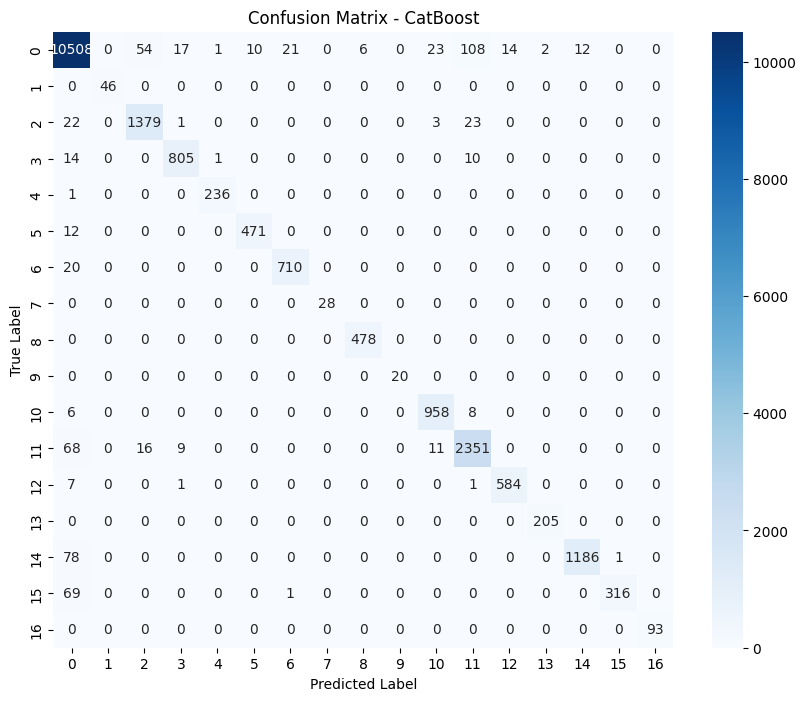

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example: Replace these with your real labels and predictions
# y_true = true class labels
# y_pred = predicted class labels from your model
y_true = y_ground_truth  # If you used train_test_split

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc  # For memory usage tracking
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap.umap_ as umap

# --------------------------------------------
# ✅ Load Indian Pines Dataset
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train CatBoost Model (Tracking Time & Memory)
# --------------------------------------------
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    task_type="GPU",
    verbose=50
)

print("Training CatBoost model...")

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

catboost_classifier.fit(X_train, y_train)

print("Extracting feature embeddings...")
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors from CatBoost
X_test_embeddings = catboost_classifier.predict_proba(X_test)

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score, pairwise_distances

# ✅ Predict Test Labels
y_pred = catboost_classifier.predict(X_test).flatten()

# ✅ Overall Accuracy
overall_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"✅ Overall Accuracy: {overall_accuracy:.2f}%")

# ✅ Kappa Score
kappa_score = cohen_kappa_score(y_test, y_pred)
print(f"✅ Cohen's Kappa: {kappa_score:.4f}")

# ✅ Adjusted Rand Index
ari_score = adjusted_rand_score(y_test, y_pred)
print(f"✅ Adjusted Rand Index: {ari_score:.4f}")

# ✅ Average Interclass Distance (using test set embeddings)
unique_classes = np.unique(y_test)
class_means = []

for cls in unique_classes:
    cls_indices = np.where(y_test == cls)[0]
    if len(cls_indices) > 0:
        cls_vectors = X_test_embeddings[cls_indices]
        class_mean = np.mean(cls_vectors, axis=0)
        class_means.append(class_mean)

class_means = np.array(class_means)
dist_matrix = pairwise_distances(class_means)
upper_tri_indices = np.triu_indices_from(dist_matrix, k=1)
avg_interclass_dist = np.mean(dist_matrix[upper_tri_indices])
print(f"✅ Average Interclass Distance: {avg_interclass_dist:.4f}")

Training CatBoost model...
0:	learn: 2.2220085	total: 73.7ms	remaining: 1m 13s
50:	learn: 0.8367107	total: 1.33s	remaining: 24.9s
100:	learn: 0.7054697	total: 2.67s	remaining: 23.8s
150:	learn: 0.6279999	total: 3.8s	remaining: 21.4s
200:	learn: 0.5726933	total: 5.17s	remaining: 20.6s
250:	learn: 0.5297149	total: 6.32s	remaining: 18.9s
300:	learn: 0.4948439	total: 9.54s	remaining: 22.2s
350:	learn: 0.4644329	total: 11s	remaining: 20.4s
400:	learn: 0.4384007	total: 12.2s	remaining: 18.2s
450:	learn: 0.4154143	total: 13.4s	remaining: 16.4s
500:	learn: 0.3951337	total: 14.8s	remaining: 14.7s
550:	learn: 0.3739629	total: 15.9s	remaining: 12.9s
600:	learn: 0.3566609	total: 17.2s	remaining: 11.4s
650:	learn: 0.3404487	total: 18.3s	remaining: 9.82s
700:	learn: 0.3256421	total: 19.8s	remaining: 8.43s
750:	learn: 0.3117101	total: 22.8s	remaining: 7.57s
800:	learn: 0.2987861	total: 24.4s	remaining: 6.07s
850:	learn: 0.2857439	total: 25.5s	remaining: 4.46s
900:	learn: 0.2731399	total: 26.6s	remain

# **SALINAS**

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# --------------------------------------------
# ✅ Load Salinas Dataset
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train CatBoost Model (Tracking Time & Memory)
# --------------------------------------------
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    task_type="GPU",
    verbose=50
)

print("Training CatBoost model...")

catboost_classifier.fit(X_train, y_train)

print("Extracting feature embeddings...")
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors from CatBoost
X_test_embeddings = catboost_classifier.predict_proba(X_test)

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score, pairwise_distances

# ✅ Predict Test Labels
y_pred = catboost_classifier.predict(X_test).flatten()

# ✅ Overall Accuracy
overall_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"✅ Overall Accuracy: {overall_accuracy:.2f}%")

# ✅ Kappa Score
kappa_score = cohen_kappa_score(y_test, y_pred)
print(f"✅ Cohen's Kappa: {kappa_score:.4f}")

# ✅ Adjusted Rand Index
ari_score = adjusted_rand_score(y_test, y_pred)
print(f"✅ Adjusted Rand Index: {ari_score:.4f}")

# ✅ Average Interclass Distance (using test set embeddings)
unique_classes = np.unique(y_test)
class_means = []

for cls in unique_classes:
    cls_indices = np.where(y_test == cls)[0]
    if len(cls_indices) > 0:
        cls_vectors = X_test_embeddings[cls_indices]
        class_mean = np.mean(cls_vectors, axis=0)
        class_means.append(class_mean)

class_means = np.array(class_means)
dist_matrix = pairwise_distances(class_means)
upper_tri_indices = np.triu_indices_from(dist_matrix, k=1)
avg_interclass_dist = np.mean(dist_matrix[upper_tri_indices])
print(f"✅ Average Interclass Distance: {avg_interclass_dist:.4f}")

Training CatBoost model...
0:	learn: 2.0383107	total: 53.4ms	remaining: 53.4s
50:	learn: 0.4245617	total: 1.31s	remaining: 24.4s
100:	learn: 0.3474873	total: 2.43s	remaining: 21.7s
150:	learn: 0.3078338	total: 3.55s	remaining: 20s
200:	learn: 0.2787361	total: 4.69s	remaining: 18.6s
250:	learn: 0.2586063	total: 5.83s	remaining: 17.4s
300:	learn: 0.2430352	total: 7.94s	remaining: 18.4s
350:	learn: 0.2279850	total: 10.2s	remaining: 18.8s
400:	learn: 0.2157942	total: 11.3s	remaining: 16.9s
450:	learn: 0.2037743	total: 12.4s	remaining: 15.1s
500:	learn: 0.1926324	total: 13.5s	remaining: 13.5s
550:	learn: 0.1838309	total: 14.6s	remaining: 11.9s
600:	learn: 0.1751720	total: 15.7s	remaining: 10.4s
650:	learn: 0.1680752	total: 16.8s	remaining: 9.01s
700:	learn: 0.1608283	total: 17.9s	remaining: 7.64s
750:	learn: 0.1544673	total: 19s	remaining: 6.3s
800:	learn: 0.1483800	total: 21s	remaining: 5.22s
850:	learn: 0.1428727	total: 23.4s	remaining: 4.1s
900:	learn: 0.1377605	total: 24.6s	remaining: 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import os

# Define Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 204, 128)  # 204 spectral bands

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 204) -> (batch, 1, 204)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        # Compute class prototypes (mean embeddings per class)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Compute Euclidean distances
        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2

        # Return negative distances as logits
        return -dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "PrototypicalNetwork_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

# ✅ Load & Process Data
df = pd.read_csv("/content/drive/MyDrive/Salinas_Reduced.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.astype(int)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to torch tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long)

# Few-shot setup
n_way = 5
k_shot = 5
q_query = 10

unique_classes = np.unique(y)
selected_classes = np.random.choice(unique_classes, n_way, replace=False)

support_samples, support_labels = [], []
query_samples, query_labels = [], []

for idx, cls in enumerate(selected_classes):
    cls_indices = np.where(y == cls)[0]
    cls_indices = np.random.permutation(cls_indices)

    support_idx = cls_indices[:k_shot]
    query_idx = cls_indices[k_shot:k_shot+q_query]

    support_samples.append(X_tensor[support_idx])
    query_samples.append(X_tensor[query_idx])
    support_labels += [idx] * k_shot
    query_labels += [idx] * q_query

support_samples = torch.cat(support_samples, dim=0).to(device)
query_samples = torch.cat(query_samples, dim=0).to(device)

# Run model
with torch.no_grad():
    logits = model(support_samples, query_samples, n_way, k_shot)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

# Ground truth
query_labels = np.array(query_labels)

# Evaluation
accuracy = accuracy_score(query_labels, preds) * 100
kappa = cohen_kappa_score(query_labels, preds)
ari = adjusted_rand_score(query_labels, preds)

# Avg Interclass Distance (on prototype space)
with torch.no_grad():
    support_embeddings = model.feature_extractor(support_samples)
    prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1).cpu().numpy()
    dist_matrix = pairwise_distances(prototypes)
    upper_tri_indices = np.triu_indices_from(dist_matrix, k=1)
    avg_inter_dist = np.mean(dist_matrix[upper_tri_indices])

# Results
print(f"Overall Accuracy: {accuracy:.2f}%")
print(f"Cohen’s Kappa: {kappa:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Average Interclass Distance: {avg_inter_dist:.4f}")

Overall Accuracy: 94.00%
Cohen’s Kappa: 0.9250
Adjusted Rand Index: 0.8565
Average Interclass Distance: 10.6121


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),  # Changed 204 → 1
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -2].values

with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()

# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

from sklearn.metrics import pairwise_distances
import numpy as np

# ✅ Compute Average Interclass Distance
unique_classes = np.unique(y_ground_truth)
class_means = []

for cls in unique_classes:
    cls_indices = np.where(y_ground_truth == cls)[0]
    if len(cls_indices) > 0:
        cls_features = deep_features[cls_indices]
        class_mean = np.mean(cls_features, axis=0)
        class_means.append(class_mean)

class_means = np.array(class_means)
dist_matrix = pairwise_distances(class_means)
upper_tri_indices = np.triu_indices_from(dist_matrix, k=1)
avg_interclass_dist = np.mean(dist_matrix[upper_tri_indices])

print(f"Average Interclass Distance: {avg_interclass_dist:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
0:	learn: 1.9242897	total: 85.6ms	remaining: 1m 25s
50:	learn: 0.2975749	total: 2.17s	remaining: 40.4s
100:	learn: 0.2531617	total: 4.14s	remaining: 36.9s
150:	learn: 0.2319426	total: 6.1s	remaining: 34.3s
200:	learn: 0.2182613	total: 8.26s	remaining: 32.8s
250:	learn: 0.2080559	total: 12.1s	remaining: 36.2s
300:	learn: 0.1990351	total: 14.1s	remaining: 32.8s
350:	learn: 0.1911501	total: 16.1s	remaining: 29.8s
400:	learn: 0.1842460	total: 18.1s	remaining: 27s
450:	learn: 0.1781138	total: 20.1s	remaining: 24.5s
500:	learn: 0.1728211	total: 22.8s	remaining: 22.8s
550:	learn: 0.1677985	total: 26s	remaining: 21.2s
600:	learn: 0.1633110	total: 28s	remaining: 18.6s
650:	learn: 0.1587324	total: 30s	remaining: 16.1s
700:	learn: 0.1547075	total: 31.9s	remaining: 13.6s
750:	learn: 0.1510224	total: 33.9s	remaining: 11.2s
800:	learn: 0.1476105	total: 37s	remaining: 9.19s
850:	learn: 0.1442652	total: 39.8s	remaining: 6.97s
900:	learn: 0.1408300

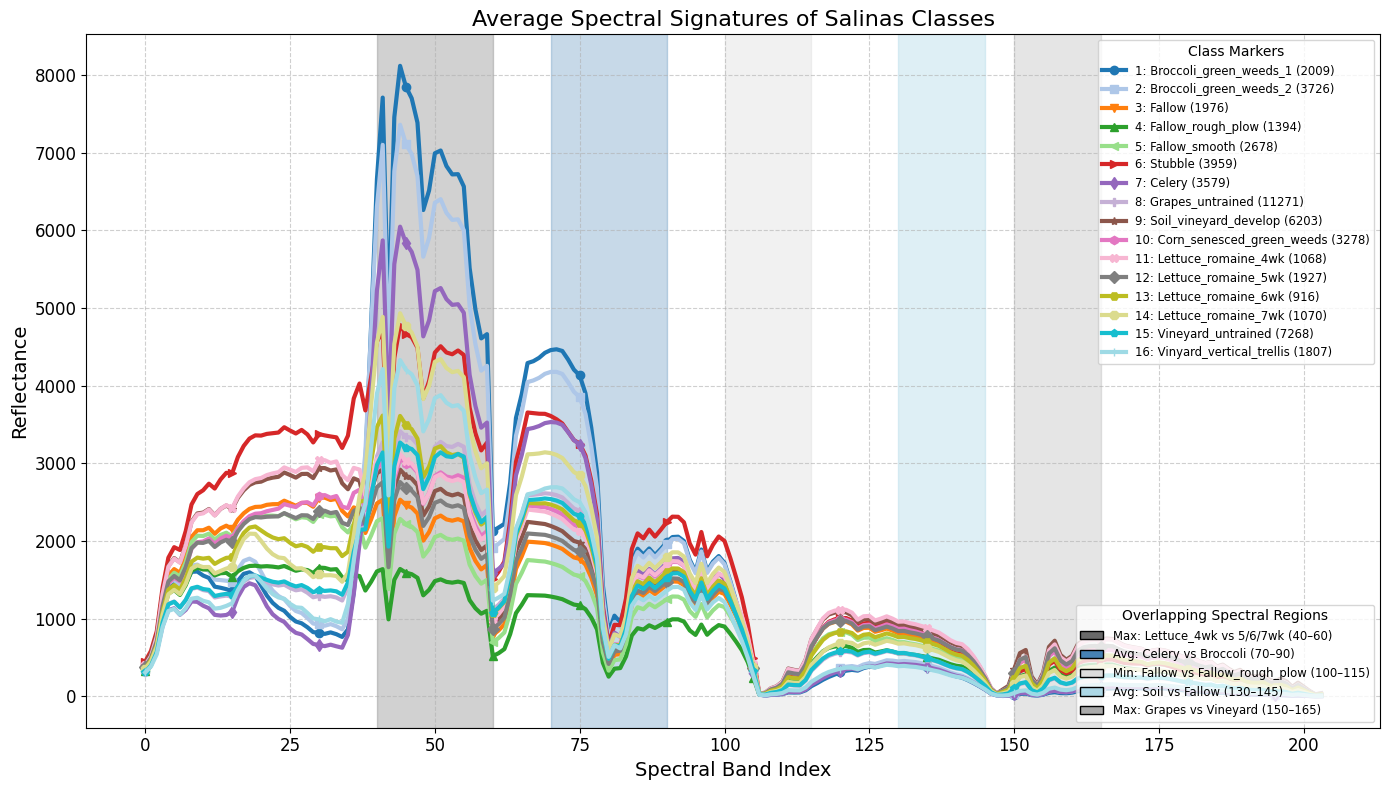

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load CSV
data = pd.read_csv('/content/drive/MyDrive/Salinas_Dataset.csv')

# Separate features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Mapping class index to Salinas class names with sample counts
class_names = {
    1: 'Broccoli_green_weeds_1 (2009)',
    2: 'Broccoli_green_weeds_2 (3726)',
    3: 'Fallow (1976)',
    4: 'Fallow_rough_plow (1394)',
    5: 'Fallow_smooth (2678)',
    6: 'Stubble (3959)',
    7: 'Celery (3579)',
    8: 'Grapes_untrained (11271)',
    9: 'Soil_vineyard_develop (6203)',
    10: 'Corn_senesced_green_weeds (3278)',
    11: 'Lettuce_romaine_4wk (1068)',
    12: 'Lettuce_romaine_5wk (1927)',
    13: 'Lettuce_romaine_6wk (916)',
    14: 'Lettuce_romaine_7wk (1070)',
    15: 'Vineyard_untrained (7268)',
    16: 'Vinyard_vertical_trellis (1807)'
}

classes_to_plot = list(class_names.keys())
wavelengths = np.arange(X.shape[1])

# Plot
plt.figure(figsize=(14, 8))

colors = plt.cm.tab20(np.linspace(0, 1, len(classes_to_plot)))
markers = ['o', 's', 'v', '^', '<', '>', 'd', 'P', '*', 'h', 'X', 'D', 'H', '8', 'p', '|']

for idx, cls in enumerate(classes_to_plot):
    class_samples = X[y == cls]
    mean_spectrum = np.mean(class_samples, axis=0)
    plt.plot(
        wavelengths,
        mean_spectrum,
        label=class_names[cls],
        linewidth=3,
        color=colors[idx],
        marker=markers[idx % len(markers)],
        markevery=15,
        markersize=6
    )

# Overlapping spectral zones
plt.axvspan(40, 60, color='dimgray', alpha=0.3)         # Max Overlap: Lettuce 4wk vs 5/6/7wk
plt.axvspan(70, 90, color='steelblue', alpha=0.3)       # Avg Overlap: Celery vs Broccoli
plt.axvspan(100, 115, color='gainsboro', alpha=0.4)     # Min Overlap: Fallow vs Fallow_rough_plow
plt.axvspan(130, 145, color='lightblue', alpha=0.4)     # Avg Overlap: Soil vs Fallow
plt.axvspan(150, 165, color='darkgrey', alpha=0.3)      # Max Overlap: Grapes vs Vineyard

# Overlap legend
overlap_patches = [
    Patch(facecolor='dimgray', edgecolor='black', label='Max: Lettuce_4wk vs 5/6/7wk (40–60)'),
    Patch(facecolor='steelblue', edgecolor='black', label='Avg: Celery vs Broccoli (70–90)'),
    Patch(facecolor='gainsboro', edgecolor='black', label='Min: Fallow vs Fallow_rough_plow (100–115)'),
    Patch(facecolor='lightblue', edgecolor='black', label='Avg: Soil vs Fallow (130–145)'),
    Patch(facecolor='darkgrey', edgecolor='black', label='Max: Grapes vs Vineyard (150–165)')
]

plt.title("Average Spectral Signatures of Salinas Classes", fontsize=16)
plt.xlabel("Spectral Band Index", fontsize=14)
plt.ylabel("Reflectance", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Class legend showing marker and color
class_legend = [
    plt.Line2D([0], [0], color=colors[i], marker=markers[i % len(markers)], linestyle='-', linewidth=3,
               markersize=6, label=f'{cls}: {class_names[cls]}')
    for i, cls in enumerate(classes_to_plot)
]

legend1 = plt.legend(handles=class_legend, title='Class Markers', loc='upper right',
                     fontsize='small', title_fontsize='medium', frameon=True)
plt.gca().add_artist(legend1)

# Overlap legend
plt.legend(handles=overlap_patches, title='Overlapping Spectral Regions',
           loc='lower right', fontsize='small', title_fontsize='medium', frameon=True)

plt.tight_layout()
plt.show()

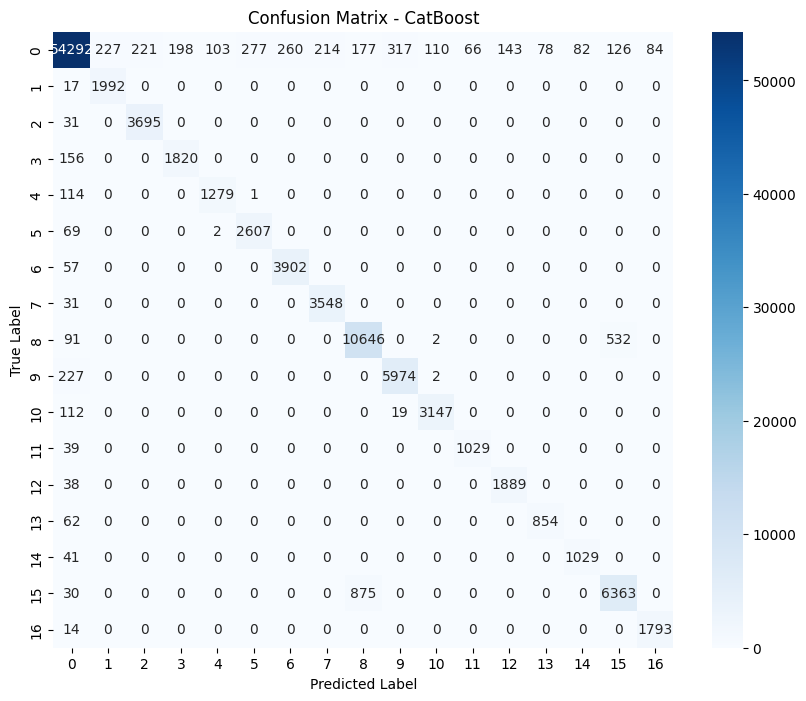

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example: Replace these with your real labels and predictions
# y_true = true class labels
# y_pred = predicted class labels from your model
y_true = y_ground_truth  # If you used train_test_split

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()